In [1010]:
df = pd.read_csv('shop1_shop_v2.csv',encoding='latin1')

In [1011]:
from xgboost import XGBRegressor

In [1012]:
df.columns

Index(['month_idx', 'hour_idx', 'mday_idx', 'year_idx', 'temperature',
       'precipitation', 'snowfraction', 'sealevelpressure', 'winddirection',
       'windspeed', 'relativehumidity', 'sunshinetime', 'totalcloudcover',
       'lowclouds', 'midclouds', 'highclouds', 'wday_x', 'month', 'hour',
       'mday', 'year', 'timestamp', 'is_resto', 'month.1', 'hour.1', 'mday.1',
       'year.1', 'price', 'count', 'n_transactions', 'last_week_price',
       'last_month_price'],
      dtype='object')

In [1013]:
features = ['precipitation', 'snowfraction', 'sealevelpressure', 'winddirection',
       'windspeed', 'relativehumidity', 'sunshinetime', 'totalcloudcover',
       'lowclouds', 'midclouds', 'highclouds', 'last_week_price','last_month_price', ] 

df[features] = df[features].fillna(0.)
features += [ 
         'month', 'mday', 'hour', 'wday_x'] 
X = df[ features ]
y = df['price']

In [1014]:
# ?XGBRegressor

In [1015]:
reg  = XGBRegressor(max_depth=20,n_estimators=300,reg_lambda=0.5,subsample=0.6, base_score=y.mean(), random_state=1234)



In [1016]:
from sklearn.model_selection import train_test_split

In [1017]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=2345)

In [1018]:
reg.fit(X_train,y_train)

XGBRegressor(base_score=608.0282621462894, booster='gbtree',
       colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=20, min_child_weight=1, missing=None,
       n_estimators=300, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=1234, reg_alpha=0, reg_lambda=0.5, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.6)

In [1019]:
reg.score(X_test,y_test)

0.5668415302199903

In [1020]:
y_pred = reg.predict(X_test)

In [1021]:
from sklearn.metrics import r2_score

In [1022]:
r2_score(y_test,y_pred)

0.5668415302199903

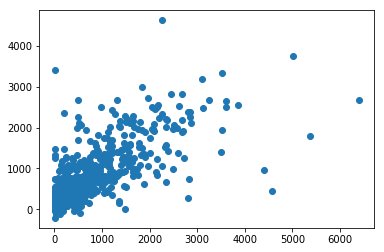

In [1023]:
plt.scatter(y_test,y_pred)

In [1024]:
list(zip(features, reg.feature_importances_))

[('precipitation', 0.058323838),
 ('snowfraction', 0.0026056701),
 ('sealevelpressure', 0.24414477),
 ('winddirection', 0.15644063),
 ('windspeed', 0.12509225),
 ('relativehumidity', 0.08932077),
 ('sunshinetime', 0.02926986),
 ('totalcloudcover', 0.01391197),
 ('lowclouds', 0.012948022),
 ('midclouds', 0.017356073),
 ('highclouds', 0.027753651),
 ('last_week_price', 0.08881369),
 ('last_month_price', 0.0),
 ('month', 0.019108249),
 ('mday', 0.036951315),
 ('hour', 0.054980144),
 ('wday_x', 0.0229791)]

In [1025]:
from sklearn.ensemble import GradientBoostingRegressor


In [1026]:
qt025 = GradientBoostingRegressor(loss='quantile',alpha=0.25,subsample=0.8,max_depth=5)
qt075 = GradientBoostingRegressor(loss='quantile',alpha=0.75,subsample=0.8,max_depth=5)


In [1027]:
qt025.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.25, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='quantile', max_depth=5,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=0.8, verbose=0,
             warm_start=False)

In [1028]:
qt075.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.75, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='quantile', max_depth=5,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=0.8, verbose=0,
             warm_start=False)

In [1029]:
y025_pred = qt025.predict(X_test)
y075_pred = qt075.predict(X_test)


In [1030]:
print( (y_test < y025_pred).sum() / y_test.count() )
print( (y_test > y075_pred).sum() / y_test.count() )

0.3425827107790822
0.24546424759871932


In [1031]:
df_test = df.loc[y_test.index]

In [1032]:
from sklearn.preprocessing import OneHotEncoder

In [1033]:
# bins = pd.get_dummies(df_test, columns=['month'])#.reshape((-1,12,1))

# print(bins.columns)
df_test['pred'] = y_pred
df_test['pred_min'] = y025_pred
df_test['pred_max'] = y075_pred
df_test['err'] = y_pred - y_test
df_test['err_min'] = y025_pred - y_test > 0.
df_test['err_max'] = y075_pred - y_test > 0.



In [1034]:
# err = (y_pred - y_test).ravel()

# means = np.average( err*bins, weights=bins, axis=1 )

In [1035]:
# # bins*err
# plt.plot(df_test.pred_min,df_test.pred_max)

In [1036]:
def prediction_profile(df,by,bins=None,range=None):
    
    if bins is not None:
        #probs = np.linspace(0,100,bins)
        #print(probs)
        #bins = np.percentile(df[by],probs)
        if range is None:
            range = df[by].min(),df[by].max()
        bins = np.linspace(*range,bins+1)
        labels = 0.5*(bins[1:]+bins[:-1])
        #print(bins)
        df[by+'_bins'] = pd.cut( df[by], bins, labels=labels ).astype(np.float)
        by = by+'_bins'
    
    meanpred = df.groupby(by)['pred'].mean()
    meanpred_min = df.groupby(by)['pred_min'].mean()
    meanpred_max = df.groupby(by)['pred_max'].mean()
    unc = 0.5*(meanpred_max-meanpred_min)
    meantrue = df.groupby(by)['price'].mean()
    stdtrue = df.groupby(by)['price'].std()
        
    mean = df.groupby(by)['err'].mean()
    maxp = df.groupby(by)['err_min'].mean() 
    minp = df.groupby(by)['err_max'].mean()

    std = df.groupby(by)['err'].std()
    
    r2 = 1. - (std/stdtrue)**2
    
    plt.scatter(meantrue.index,meanpred)
    plt.plot(meanpred,color='red')
    plt.fill_between(mean.index, meanpred - std, meanpred+std, color='red', alpha=0.5)
    plt.show()
    
    plt.scatter(meantrue.index,meanpred)
    plt.plot(meanpred,color='orange')
    plt.fill_between(meanpred.index, meanpred - unc, meanpred + unc, color='orange', alpha=0.5)
    # plt.plot(unc)
    plt.show()

    plt.plot(r2)
    plt.show()
    
    
    plt.plot(minp)
    plt.plot(maxp)
    plt.show()

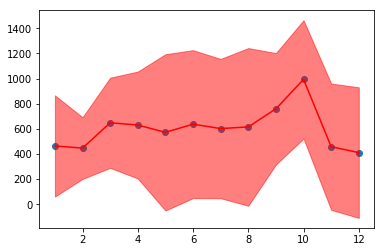

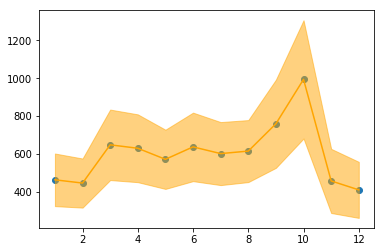

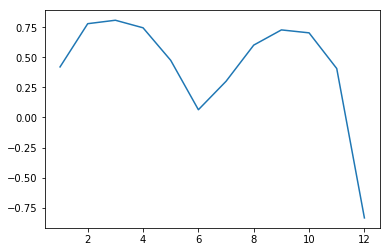

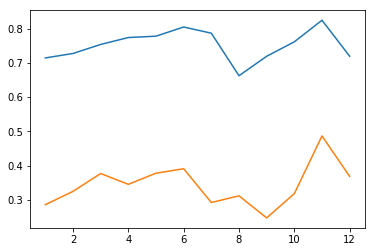

In [1037]:
prediction_profile(df_test,'month')

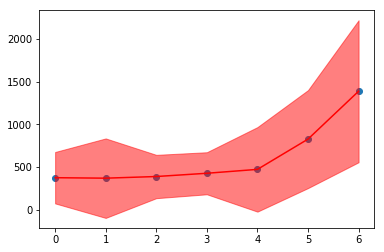

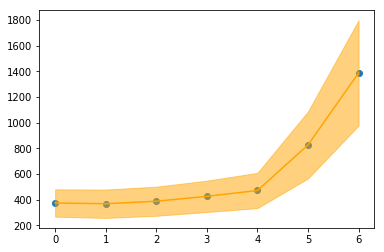

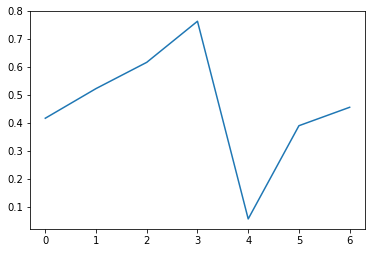

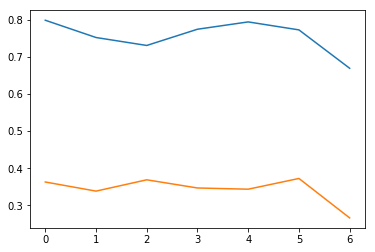

In [1038]:
prediction_profile(df_test,'wday_x')

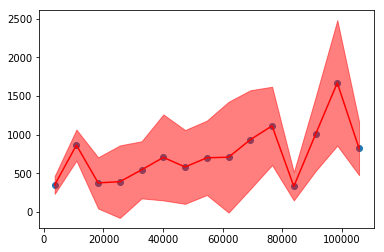

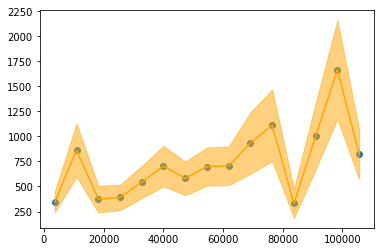

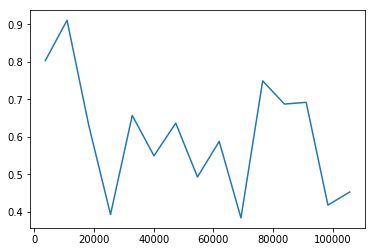

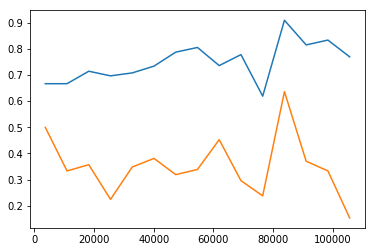

In [1039]:
prediction_profile(df_test,'last_week_price',bins=15)

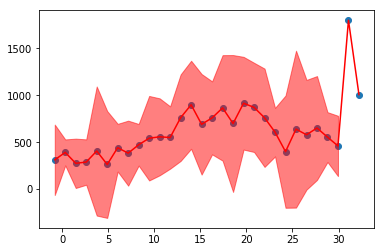

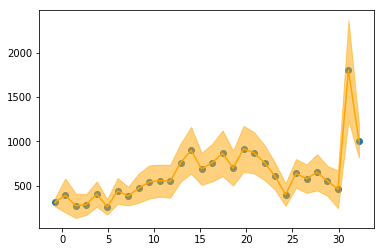

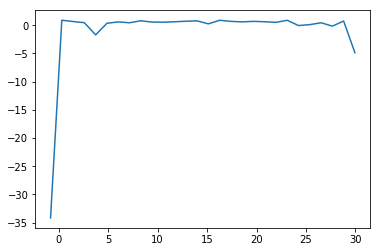

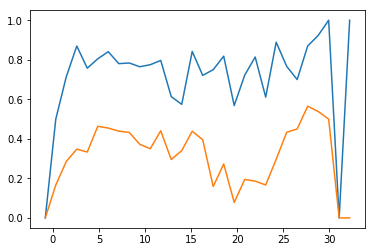

In [1040]:
prediction_profile(df_test,'temperature',bins=30)

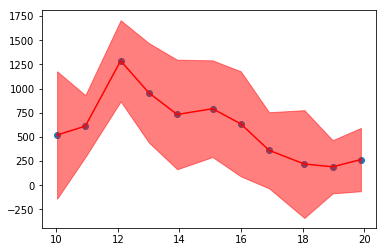

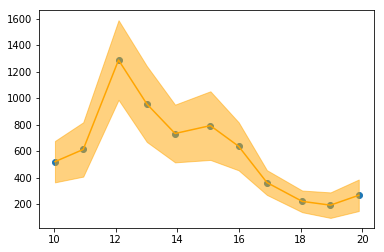

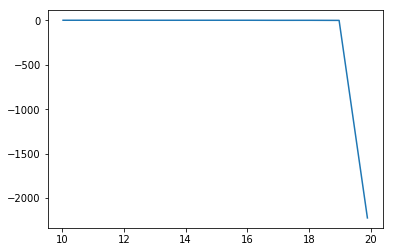

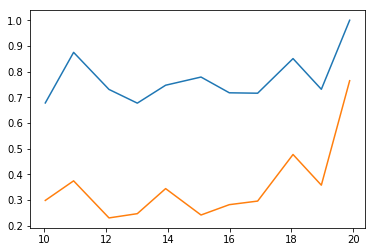

In [1041]:
prediction_profile(df_test,'hour',bins=48,range=[9,20])

/home/musella/.local/lib/python3.5/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


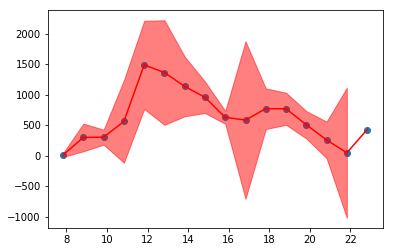

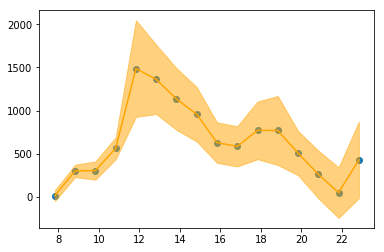

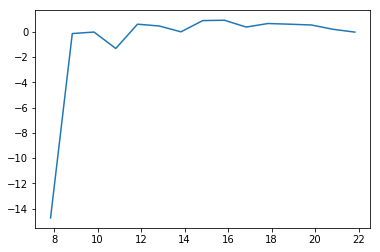

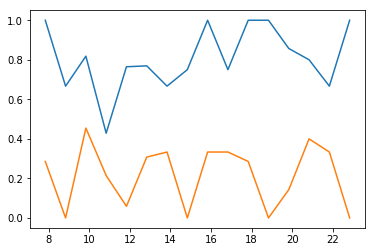

In [885]:
prediction_profile(df_test[ df_test['wday_x'] == 0],'hour',bins=48)

/home/musella/.local/lib/python3.5/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


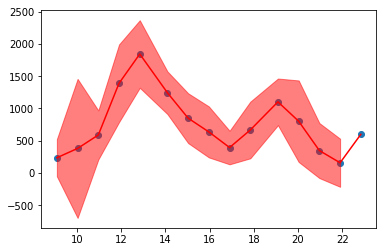

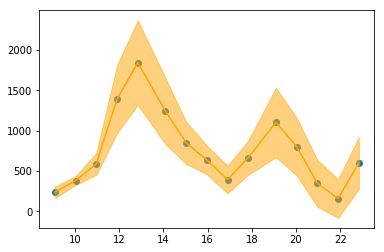

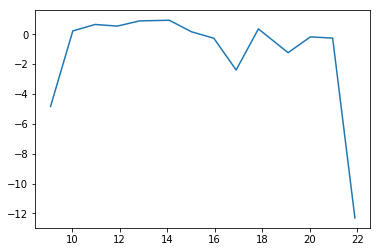

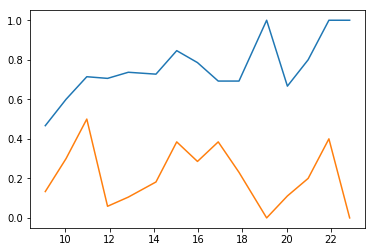

In [886]:
prediction_profile(df_test[ df_test['wday_x'] == 1],'hour',bins=48)

/home/musella/.local/lib/python3.5/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


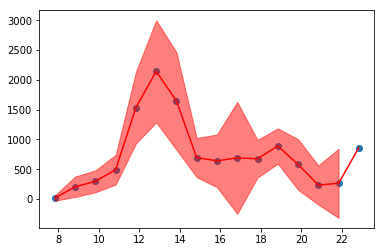

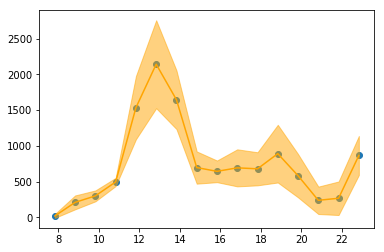

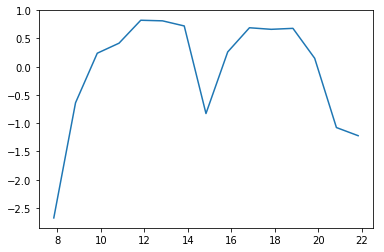

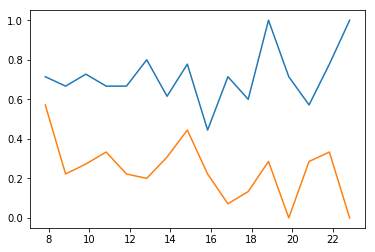

In [887]:
prediction_profile(df_test[ df_test['wday_x'] == 2],'hour',bins=48)

/home/musella/.local/lib/python3.5/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


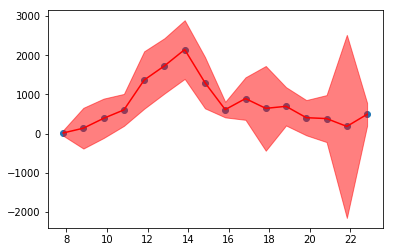

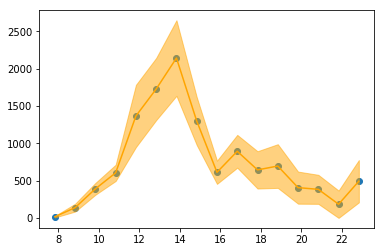

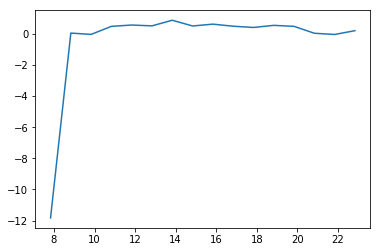

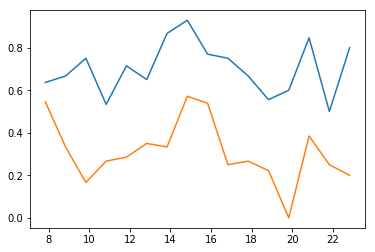

In [888]:
prediction_profile(df_test[ df_test['wday_x'] == 3],'hour',bins=48)

/home/musella/.local/lib/python3.5/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


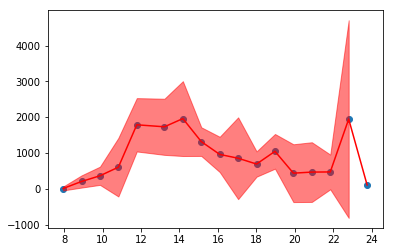

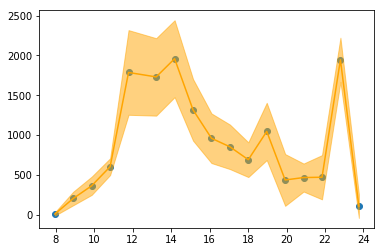

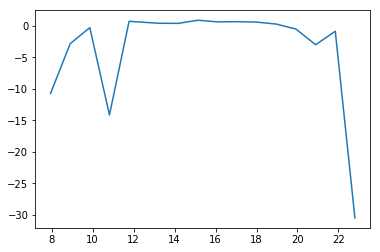

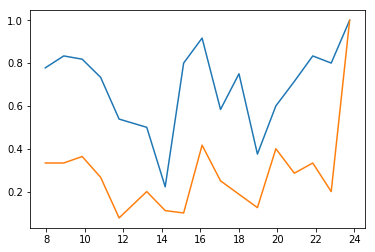

In [891]:
prediction_profile(df_test[ df_test['wday_x'] == 4],'hour',bins=48)

/home/musella/.local/lib/python3.5/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


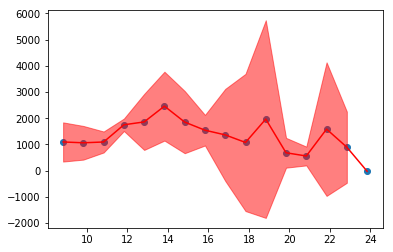

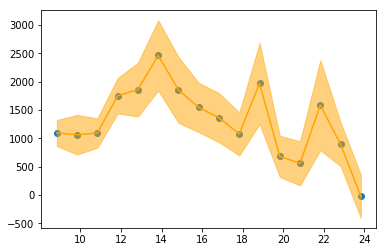

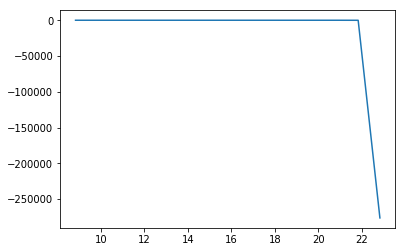

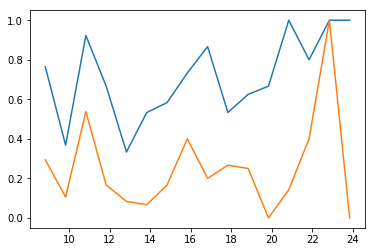

In [892]:
prediction_profile(df_test[ df_test['wday_x'] == 5],'hour',bins=48)

/home/musella/.local/lib/python3.5/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


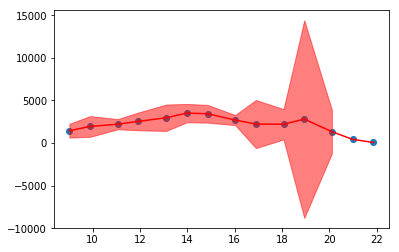

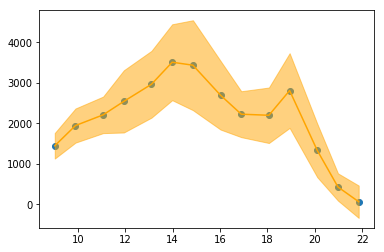

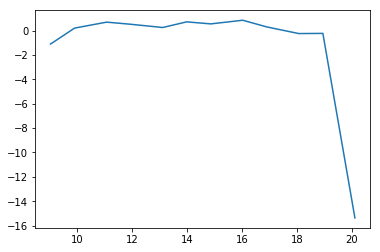

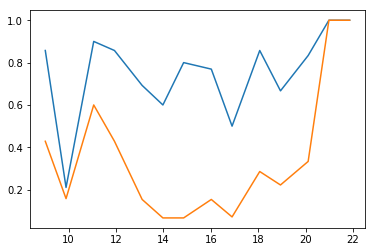

In [894]:
prediction_profile(df_test[ df_test['wday_x'] == 6],'hour',bins=48)

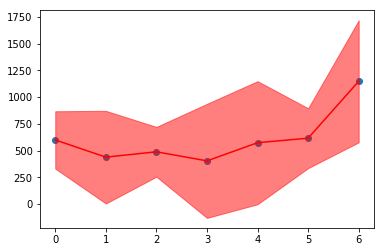

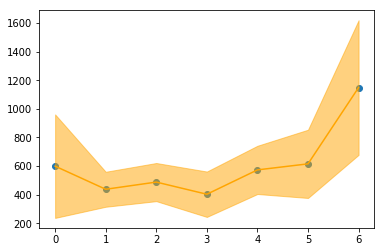

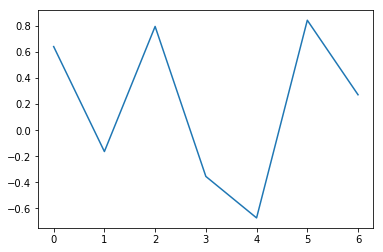

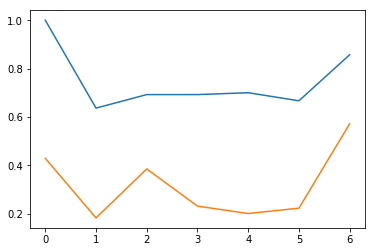

In [897]:
prediction_profile(df_test[ df_test['month'] == 1],'wday_x')

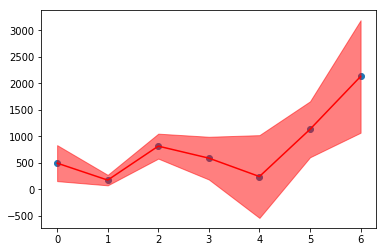

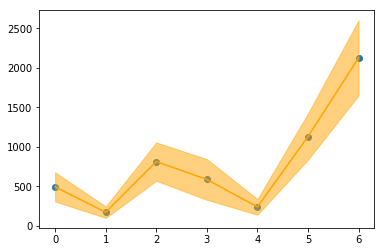

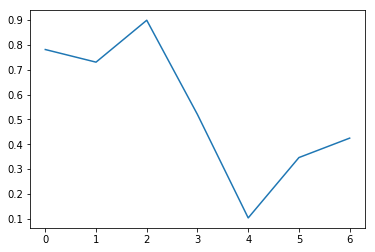

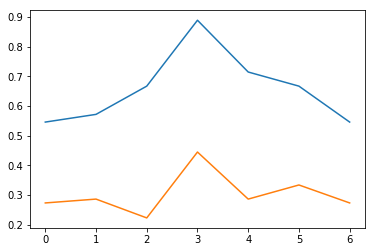

In [898]:
prediction_profile(df_test[ df_test['month'] == 2],'wday_x')

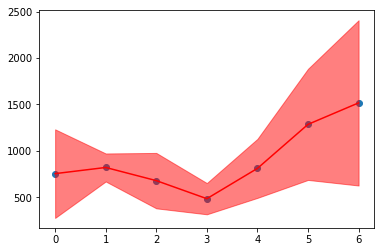

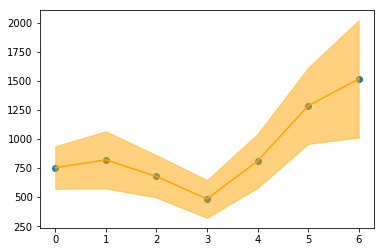

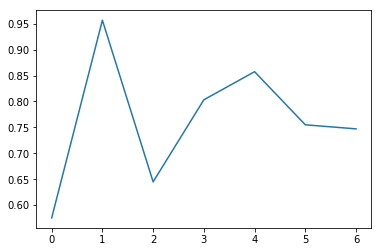

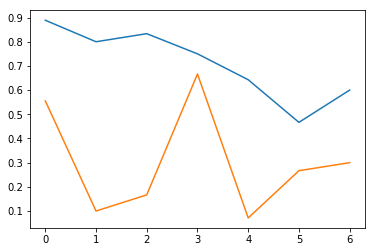

In [900]:
prediction_profile(df_test[ df_test['month'] == 3],'wday_x')

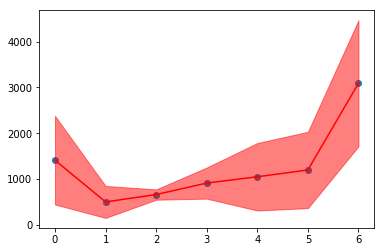

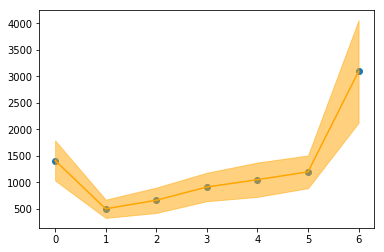

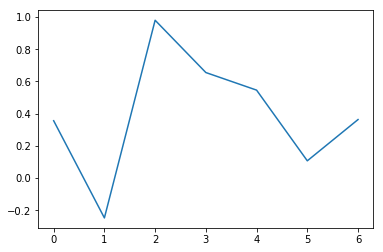

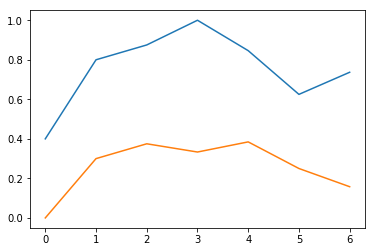

In [901]:
prediction_profile(df_test[ df_test['month'] == 4],'wday_x')

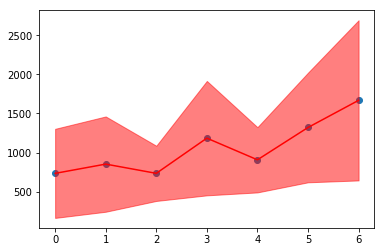

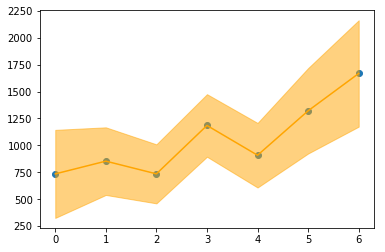

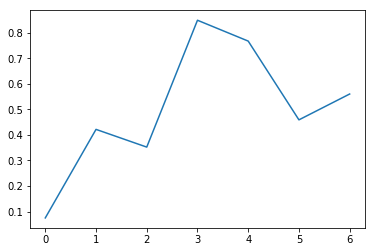

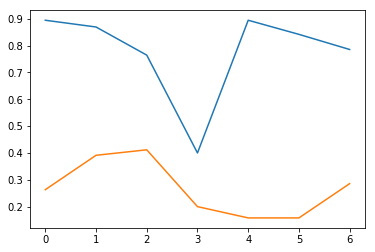

In [902]:
prediction_profile(df_test[ df_test['month'] == 5],'wday_x')

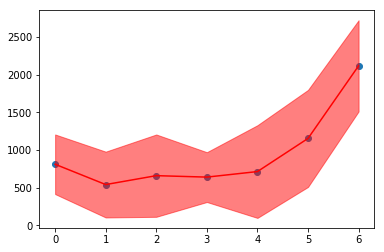

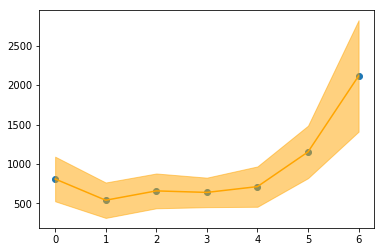

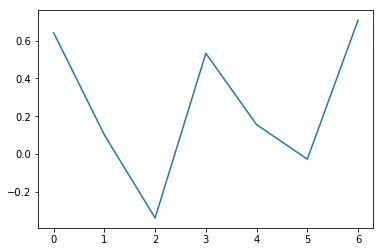

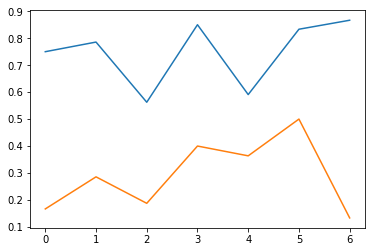

In [903]:
prediction_profile(df_test[ df_test['month'] == 6],'wday_x')

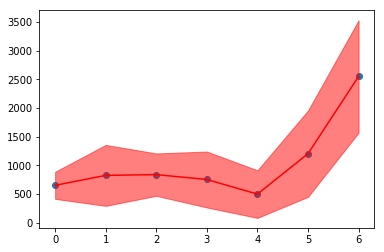

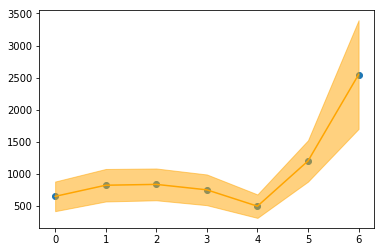

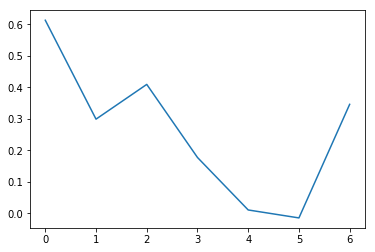

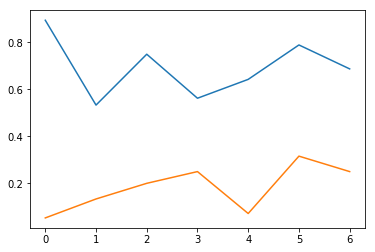

In [904]:
prediction_profile(df_test[ df_test['month'] == 7],'wday_x')

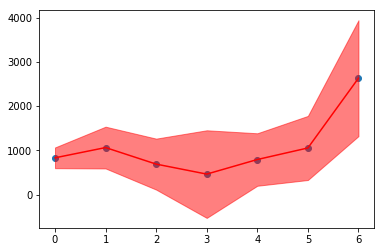

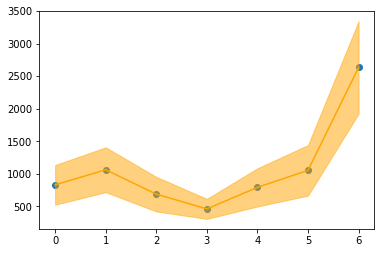

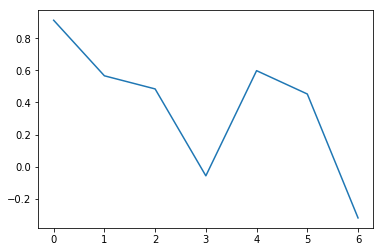

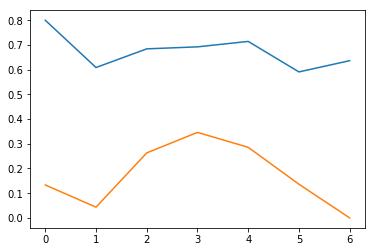

In [905]:
prediction_profile(df_test[ df_test['month'] == 8],'wday_x')

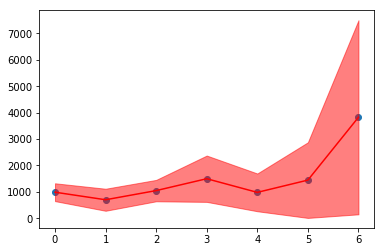

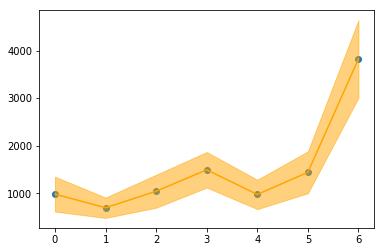

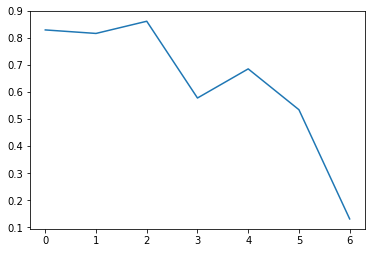

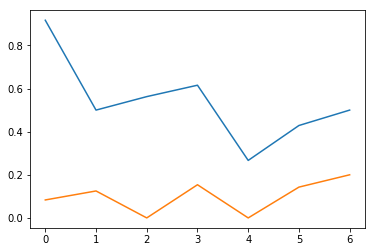

In [906]:
prediction_profile(df_test[ df_test['month'] == 9],'wday_x')

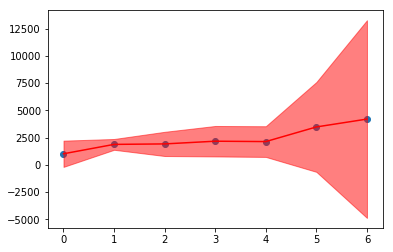

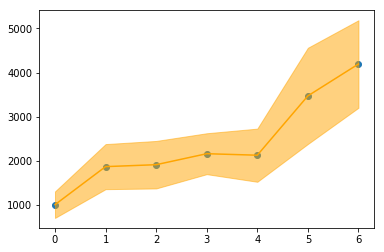

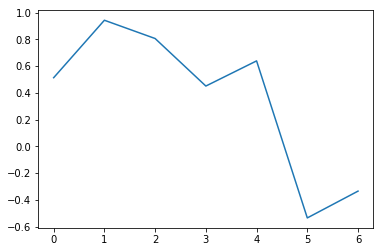

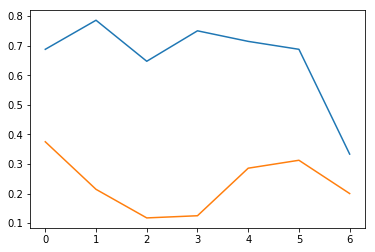

In [907]:
prediction_profile(df_test[ df_test['month'] == 10],'wday_x')

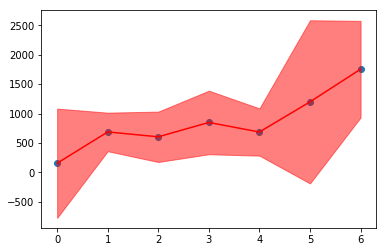

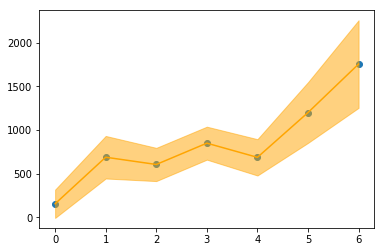

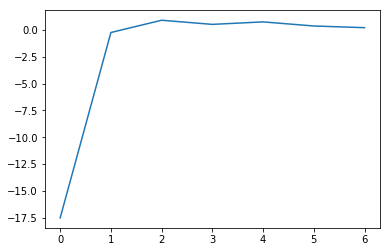

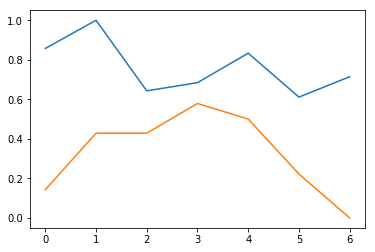

In [908]:
prediction_profile(df_test[ df_test['month'] == 11],'wday_x')

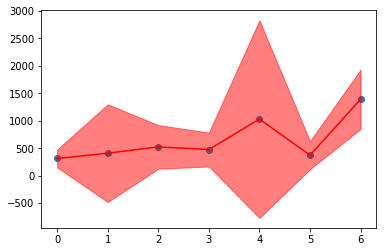

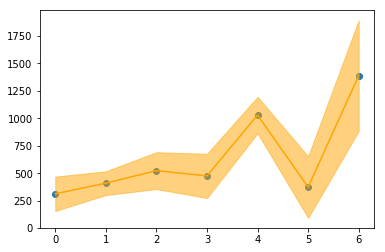

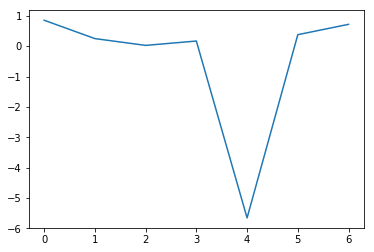

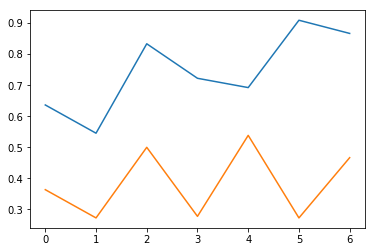

In [909]:
prediction_profile(df_test[ df_test['month'] == 12],'wday_x')